# Using convlutions to generalize
---
This chapter covers
- Understanging convolution
- Building a convolutional neural network
- Creating custom nn.Module subclasses 
- The differece between the module and functional APIs
- Design choices for neural networks

we need to use the dataset from the last chapter

In [1]:
# first download the dataset using datasets module in torchvision
from torchvision import datasets
from torchvision import transforms
import torch

data_path = './data/'

tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

# build a normalize transform
norm = transforms.Normalize(mean, std)

# use compose to put two transforms together
trans = transforms.Compose([
    transforms.ToTensor(),
    norm
])

# normalized dataset
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=trans)
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=trans)

# pick out these two kinds
label_map = {0:0, 2:1}  # reset the label to 0, 1
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
Files already downloaded and verified


In [2]:
# implement a conv
import torch
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)   # in_ch=3, out_ch=16 
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
# test on a single image
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

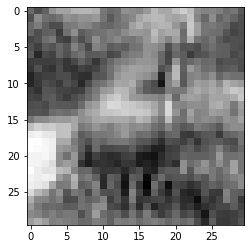

In [4]:
import matplotlib.pyplot as plt

plt.imshow(output[0, 0].detach(), cmap='gray')

In [5]:
# add padding to keep the same dimension
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [6]:
# try maxpooling layer

pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

## Subclassing nn.Module
---
to do more complex things other than simply put layers together

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, X):
        out = self.pool1(self.act1(self.conv1(X)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

tips: assigning a module to an attribute in the init function will automatically make it a subclass of this module, so that PyTorch can track it.  
Also, if we don't need the module to be tracked as a submodule, for example when it doesn't have any weights, we needn't register it.  
So we can use the functional API for those.

### The fucntional API
---
the functional API contains modules that don't store weights themselves.  
Instead, they take input features and weights as input, for example:  
    linear(input, weight, bias=None)

In [10]:
# rewrite the model with F
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, X):
        out = F.max_pool2d(torch.tanh(self.conv1(X)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out